In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset,DataLoader


In [40]:
# data = pd.read_csv("USD_CNY_5_years.csv")
data = pd.read_csv("USD_EUR_5_years.csv")
# data = pd.read_csv("USD_JPY_5_years.csv")
data.head(20)

,date,open,high,low,close
0,4/14/23,0.9047,0.9111,0.9027,0.9093
1,4/13/23,0.9096,0.9105,0.9033,0.9050
2,4/12/23,0.9159,0.9161,0.9086,0.9094
3,4/11/23,0.9203,0.9205,0.9149,0.9161
4,4/10/23,0.9165,0.9229,0.9155,0.9205
5,4/7/23,0.9154,0.9188,0.9150,0.9168
6,4/6/23,0.9166,0.9184,0.9138,0.9156
7,4/5/23,0.9125,0.9178,0.9113,0.9164
8,4/4/23,0.9170,0.9185,0.9112,0.9125
9,4/3/23,0.9221,0.9267,0.9162,0.9170


In [41]:
# df = pd.read_csv('USD_CNY_5_years.csv', index_col=0)
df = pd.read_csv('USD_EUR_5_years.csv', index_col=0)
# df = pd.read_csv('USD_JPY_5_years.csv', index_col=0)
print(df.columns)

df.index = list(map(lambda x:datetime.datetime.strptime(x, '%m/%d/%y'), df.index))
df.sort_index(inplace=True)
# stk_path = "./USD_CNY_5_years.csv"
# df = pd.read_csv(stk_path, sep=",")
# df.loc[:, 'date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
# df.sort_values(by='date', inplace=True, ascending=True)
# df.index = list(map(lambda x:datetime.datetime.strptime(x, '%m/%d/%y'), df.index))

df.head()

Index(['open', 'high', 'low', 'close'], dtype='object')


,open,high,low,close
2018-04-16,0.8109,0.8110,0.8067,0.8074
2018-04-17,0.8074,0.8103,0.8053,0.8080
2018-04-18,0.8080,0.8097,0.8064,0.8075
2018-04-19,0.8073,0.8107,0.8062,0.8099
2018-04-20,0.8100,0.8153,0.8093,0.8138


In [42]:
print(df.describe().loc()[['min','max','mean'],:])

          open      high       low     close
min   0.807300  0.809700  0.805300  0.807400
max   1.041500  1.048100  1.034200  1.041900
mean  0.889306  0.892406  0.886234  0.889366


### Data Processing

In [43]:
base1 = df['close']
base2 = df.shift(1)
print(base2)
base2.columns=[f'v{j}-1' for j in range(len(df.columns))]
base3=pd.concat([base1,base2],axis=1)
for i in range(2,7):
    base4=df.shift(i)
    base4.columns=[f'v{j}-{i}' for j in range(len(df.columns))]
    base3=pd.concat([base3,base4],axis=1)
base3.dropna(inplace=True)
x=base3.drop(columns=['close'])
y=base3['close']
print(x)
print(y)

              open    high     low   close
2018-04-16     NaN     NaN     NaN     NaN
2018-04-17  0.8109  0.8110  0.8067  0.8074
2018-04-18  0.8074  0.8103  0.8053  0.8080
2018-04-19  0.8080  0.8097  0.8064  0.8075
2018-04-20  0.8073  0.8107  0.8062  0.8099
...            ...     ...     ...     ...
2023-04-10  0.9154  0.9188  0.9150  0.9168
2023-04-11  0.9165  0.9229  0.9155  0.9205
2023-04-12  0.9203  0.9205  0.9149  0.9161
2023-04-13  0.9159  0.9161  0.9086  0.9094
2023-04-14  0.9096  0.9105  0.9033  0.9050

[1305 rows x 4 columns]
              v0-1    v1-1    v2-1    v3-1    v0-2    v1-2    v2-2    v3-2  \
2018-04-24  0.8141  0.8195  0.8135  0.8188  0.8100  0.8153  0.8093  0.8138   
2018-04-25  0.8186  0.8206  0.8164  0.8173  0.8141  0.8195  0.8135  0.8188   
2018-04-26  0.8172  0.8221  0.8167  0.8214  0.8186  0.8206  0.8164  0.8173   
2018-04-27  0.8215  0.8264  0.8190  0.8258  0.8172  0.8221  0.8167  0.8214   
2018-04-30  0.8259  0.8291  0.8240  0.8243  0.8215  0.8264  0.8190  0

In [44]:
from sklearn.preprocessing import StandardScaler
x_train,x_test=x.iloc[:int(len(x)*0.9),:],x.iloc[int(len(x)*0.9):,:]
y_train,y_test=y[:int(len(x)*0.9)],y[int(len(x)*0.9):]
print(x_train)


              v0-1    v1-1    v2-1    v3-1    v0-2    v1-2    v2-2    v3-2  \
2018-04-24  0.8141  0.8195  0.8135  0.8188  0.8100  0.8153  0.8093  0.8138   
2018-04-25  0.8186  0.8206  0.8164  0.8173  0.8141  0.8195  0.8135  0.8188   
2018-04-26  0.8172  0.8221  0.8167  0.8214  0.8186  0.8206  0.8164  0.8173   
2018-04-27  0.8215  0.8264  0.8190  0.8258  0.8172  0.8221  0.8167  0.8214   
2018-04-30  0.8259  0.8291  0.8240  0.8243  0.8215  0.8264  0.8190  0.8258   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2022-10-10  1.0209  1.0274  1.0185  1.0264  1.0110  1.0216  1.0070  1.0209   
2022-10-11  1.0268  1.0324  1.0252  1.0302  1.0209  1.0274  1.0185  1.0264   
2022-10-12  1.0304  1.0334  1.0229  1.0302  1.0268  1.0324  1.0252  1.0302   
2022-10-13  1.0299  1.0339  1.0274  1.0298  1.0304  1.0334  1.0229  1.0302   
2022-10-14  1.0299  1.0377  1.0195  1.0222  1.0299  1.0339  1.0274  1.0298   

              v0-3    v1-3  ...    v2-4    v3-4    v0-5    v1-5

In [45]:
print(x_test)


              v0-1    v1-1    v2-1    v3-1    v0-2    v1-2    v2-2    v3-2  \
2022-10-17  1.0224  1.0296  1.0195  1.0284  1.0299  1.0377  1.0195  1.0222   
2022-10-18  1.0280  1.0281  1.0148  1.0159  1.0224  1.0296  1.0195  1.0284   
2022-10-19  1.0156  1.0187  1.0126  1.0138  1.0280  1.0281  1.0148  1.0159   
2022-10-20  1.0138  1.0246  1.0128  1.0229  1.0156  1.0187  1.0126  1.0138   
2022-10-21  1.0230  1.0248  1.0152  1.0215  1.0138  1.0246  1.0128  1.0229   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-04-10  0.9154  0.9188  0.9150  0.9168  0.9166  0.9184  0.9138  0.9156   
2023-04-11  0.9165  0.9229  0.9155  0.9205  0.9154  0.9188  0.9150  0.9168   
2023-04-12  0.9203  0.9205  0.9149  0.9161  0.9165  0.9229  0.9155  0.9205   
2023-04-13  0.9159  0.9161  0.9086  0.9094  0.9203  0.9205  0.9149  0.9161   
2023-04-14  0.9096  0.9105  0.9033  0.9050  0.9159  0.9161  0.9086  0.9094   

              v0-3    v1-3  ...    v2-4    v3-4    v0-5    v1-5

In [46]:
import xgboost as xgb
import sklearn.feature_selection as feature_selection
#Data feature processing
model1=xgb.XGBRegressor()
rfa=feature_selection.RFECV(model1,cv=5,scoring='neg_mean_absolute_error')
rfa.fit(x_train,y_train)

# plt.bar(x_train.columns,rfa.grid_scores_)
# plt.show()

RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, gpu_id=None,
                             grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=None,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_s

In [47]:
col_select = x_train.columns[rfa.support_]
x_train,x_test = x_train.loc[:,col_select],x_test.loc[:,col_select]

In [48]:
#Data standardization
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
std.fit(x_train)
x_train_std,x_test_std=std.transform(x_train),std.transform(x_test)

In [49]:
#Model Tuning
from sklearn.model_selection import GridSearchCV
params=dict(gamma=[0.02, 0.05, 0.1,0.3,0.5,0.7],min_child_weight=[1,3,5],subsample=[0.2,0.4,0.7,0.9],colsample_bytree=[0.1, 0.2,0.4,0.7],n_estimators=[50, 100,200,300],max_depth=[3,4,5,6,7])
model=GridSearchCV(xgb.XGBRegressor(),params,scoring='neg_mean_squared_error',n_jobs=5,cv=5)

In [50]:
#Model fitting
model.fit(x_train_std,y_train)
print(model.best_params_)

[[ 1.8908969 ]
 [ 1.93401491]
 [ 2.08492796]
 [ 2.1100148 ]
 [ 1.72469655]
 [ 1.93401491]
 [ 2.03397031]
 [ 2.23623299]
 [ 2.12451814]
 [ 2.18723525]
 [ 2.23231317]
 [ 1.77212637]
 [ 1.94263851]
 [ 2.02848256]
 [ 1.99555608]
 [ 1.77565421]
 [ 1.47226018]
 [ 1.33663443]
 [ 1.2288394 ]
 [ 1.38916001]
 [ 1.66237143]
 [ 1.52360982]
 [ 1.69725782]
 [ 1.59847837]
 [ 1.67569881]
 [ 1.64238035]
 [ 1.69804178]
 [ 1.86933789]
 [ 1.67099503]
 [ 1.39895956]
 [ 1.22256769]
 [ 1.13084391]
 [ 0.90153448]
 [ 1.02892861]
 [ 0.93955672]
 [ 0.91878168]
 [ 0.88350331]
 [ 0.96738744]
 [ 0.83293764]
 [ 0.85959241]
 [ 0.94504447]
 [ 0.94190862]
 [ 0.96699546]
 [ 0.89957457]
 [ 0.98189077]
 [ 0.98933843]
 [ 1.0073696 ]
 [ 0.90153448]
 [ 0.89761466]
 [ 0.96581951]
 [ 0.9074142 ]
 [ 0.65145   ]
 [ 0.65654576]
 [ 0.68947224]
 [ 0.61146784]
 [ 0.57775739]
 [ 0.40371741]
 [ 0.15480888]
 [ 0.18420752]
 [ 0.13324987]
 [-0.01962309]
 [-0.12153839]
 [ 0.02741474]
 [ 0.14853716]
 [ 0.12149041]
 [ 0.18930329]
 [ 0.25280

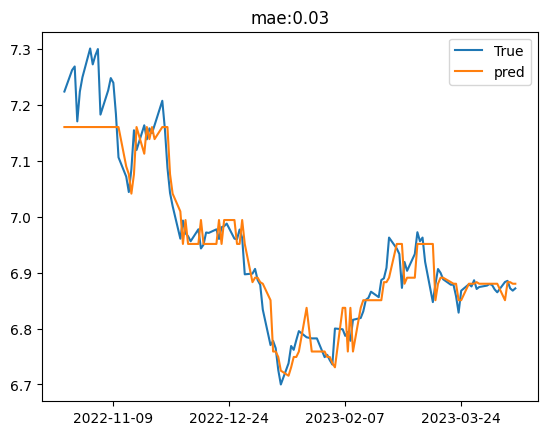

In [ ]:
#Result prediction
from sklearn.metrics import mean_absolute_error
plt.plot(y_test.index,y_test,label='True')
y_pred=model.predict(x_test_std)
y_pred_train=model.predict(x_train_std)
plt.plot(y_test.index,y_pred,label='pred')
plt.title('mae:%.2f'%(mean_absolute_error(y_test,y_pred)))
gca=plt.gca()
mul=plt.MultipleLocator(45)
gca.xaxis.set_major_locator(mul)
plt.legend()
plt.show()

In [ ]:
import csv
header = ['date','close prediction']
data =[]
for i in range(len(y_test)):
    temp = [y_test.index[i].strftime('%d/%m/%y'),y_pred[i]]
    data.append(temp)

with open("USD_EUR_5_years_prediction.csv",'w',newline='') as csvfile:
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(header)
    csvwriter.writerows(data)
#dataframe.to_csv("USD_CNY_5_years_prediction.csv")
print(data)

[['21/10/22', 7.1608496], ['24/10/22', 7.1608496], ['25/10/22', 7.1608496], ['26/10/22', 7.1608496], ['27/10/22', 7.1608496], ['28/10/22', 7.1608496], ['31/10/22', 7.1608496], ['01/11/22', 7.1608496], ['02/11/22', 7.1608496], ['03/11/22', 7.1608496], ['04/11/22', 7.1608496], ['07/11/22', 7.1608496], ['08/11/22', 7.1608496], ['09/11/22', 7.1608496], ['10/11/22', 7.1608496], ['11/11/22', 7.1608496], ['14/11/22', 7.090285], ['15/11/22', 7.076475], ['16/11/22', 7.041666], ['17/11/22', 7.076475], ['18/11/22', 7.1608496], ['21/11/22', 7.113088], ['22/11/22', 7.1608496], ['23/11/22', 7.1392345], ['24/11/22', 7.1608496], ['25/11/22', 7.1392345], ['28/11/22', 7.1608496], ['29/11/22', 7.1608496], ['30/11/22', 7.1608496], ['01/12/22', 7.076475], ['02/12/22', 7.041666], ['05/12/22', 7.0098305], ['06/12/22', 6.9515786], ['07/12/22', 6.9944015], ['08/12/22', 6.9515786], ['09/12/22', 6.9515786], ['12/12/22', 6.9515786], ['13/12/22', 6.9944015], ['14/12/22', 6.9515786], ['15/12/22', 6.9515786], ['16/1